In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('image', cmap='Blues')
from slmsuite.holography.algorithms import Hologram, SpotHologram
from tools.IonChainTools import *
from scipy import fft

d:\py\Python3\lib\site-packages\slmsuite\holography\algorithms.py:72: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


cupy not installed. Using numpy.


In [2]:
def ion_position_act(N,v): #N is the number of the ions, v is the trap frequency
    return calcPositions(N)*lengthScale(v)

def ion_position_cam(N,v,pixel_size,magnititude = 200):
    position = ion_position_act(N,v)*magnititude//pixel_size[0]
    return position

In [3]:
target_size = (1200,1920)
target = np.zeros(target_size, dtype=int)
pixel_size = np.array([7.8e-6,7.8e-6]) 
slm_size = target_size
#Create a virtual SLM and camera
from slmsuite.hardware.slms.slm import SLM
from slmsuite.hardware.cameras.camera import Camera
from slmsuite.hardware.cameraslms import FourierSLM

wav_um = 0.730
slm = SLM (slm_size[1],slm_size[0], dx_um=7.8, dy_um=7.8, wav_um=wav_um)
camera = Camera(target_size[1],target_size[0])

slm.set_measured_amplitude_analytic(800)
fs = FourierSLM(camera, slm)

In [4]:
ions = [0,1,3]
N = 6
v = 2*np.pi*1e6 
mag = 100 * 7.8 / 2.2
position = np.array(ion_position_cam(N,v,pixel_size,magnititude= mag))
dy = target_size[0]//8 

position_all_plot = np.column_stack((np.full(position.shape,target_size[0]//2+dy),position+target_size[1]//2))
position_all_ion =  np.column_stack((position+target_size[1]//2,np.full(position.shape,target_size[0]//2+dy)))

num_superpixels_x = 6
num_superpixels_y = 8
superpixel_size = (slm_size[0] // num_superpixels_y, slm_size[1] // num_superpixels_x)

x_coordinates, y_coordinates = np.meshgrid(np.arange(slm_size[1]), np.arange(slm_size[0]))

(center_x, center_y) = (slm_size[1]//2,slm_size[0]//2)

blaze_grating_phase_all = []
for position1 in position_all_ion:
    (x, y) = position1
    shift_x,shift_y = x - center_x,y- center_y
    fx,fy = shift_x/slm_size[1], shift_y/slm_size[0]
    blaze_grating_phase_all.append(2 * np.pi * (fx * x_coordinates  + fy * y_coordinates)) 
blaze_grating_phase_all = np.array(blaze_grating_phase_all)


pos_ref = (target_size[1] //2, target_size[0] - dy)
(x, y) = pos_ref
shift_x,shift_y = x - center_x,y- center_y
fx,fy = shift_x/slm_size[1], shift_y/slm_size[0]
blaze_grating_phase_gap = 2 * np.pi * (fx * x_coordinates  + fy * y_coordinates)


In [5]:
#circular superpixels

num_circle_x = 6
num_circle_y = 8
radius_x = (slm_size[1] // num_circle_x)//2
radius_y = (slm_size[0] // num_circle_y)//2


In [6]:
import random

def calculate_intensity(blaze_phase_mod):
    nearfield = slm._get_measured_amplitude() * np.exp(1j * blaze_phase_mod)
    farfield = fft.fftshift(fft.fft2(fft.fftshift(nearfield), norm="ortho"))
    am_ff = np.abs(farfield)
    intensity = am_ff ** 2
    cal = []

    for i, pos in enumerate(position_all_plot):
        cal.append(np.sum(intensity[int(pos[0])-60:int(pos[0])+60, int(pos[1])-60:int(pos[1])+60]))

    return cal,am_ff

def objective_function(blaze_phase_mod):
    cal,_ = calculate_intensity(blaze_phase_mod)
    all_indices = range(N)
    null_indices = [i for i in all_indices if i not in ions]

    cal_ions = [cal[i] for i in ions]
    cal_null = [cal[i] for i in null_indices]

    if not cal_ions or not cal_null:
        return float('inf') 

    return max(cal_null) / min(cal_ions)

def fidelity_calculation(intensity):
    background = 0
    inten = np.array([ i- background for i in intensity])
    all = range(N)
    undesire = [ i for i in all if i not in ions]
    Omega_desire = np.sqrt(inten[ions])
    Omega_undesire = np.sqrt(inten[undesire])
    F1 = sum(Omega_desire)/(len(ions)*max(Omega_desire))
    F2 = 1-sum(Omega_undesire)/(len(undesire)*max(Omega_desire))
    F = F1*F2
    return F1, F2, F

def blaze_RM_compose(blaze_grating_phase, num_superpixels_x, num_superpixels_y,random_map_superpixels):
    
    # combined_blaze_grating_phase = np.zeros(slm_size)
    field  = np.zeros(slm_size, dtype=complex)
    field_array = np.zeros(slm_size, dtype=complex)
    for i in range(num_superpixels_y):
        for j in range(num_superpixels_x):   
            phase_index = random_map_superpixels[i, j]
            y_start, y_end = i * superpixel_size[0], (i + 1) * superpixel_size[0]
            x_start, x_end = j * superpixel_size[1], (j + 1) * superpixel_size[1]
            field[y_start:y_end, x_start:x_end] = np.exp(1j*blaze_grating_phase[phase_index][y_start:y_end, x_start:x_end])
            field_array += field
            # combined_blaze_grating_phase[y_start:y_end, x_start:x_end] = blaze_grating_phase[phase_index][y_start:y_end, x_start:x_end]
    combined_blaze_grating_phase = np.angle(field_array)
    return combined_blaze_grating_phase

import numpy as np

def blaze_RM_compose_diamond(blaze_grating_phase, slm_size, num_superpixels_x, num_superpixels_y, random_map_diamonds, random_map_corners, blaze_grating_phase_gap):
    field = np.zeros(slm_size, dtype=complex)
    superpixel_width, superpixel_height = slm_size[1] // num_superpixels_x, slm_size[0] // num_superpixels_y

    for y in range(num_superpixels_y):
        for x in range(num_superpixels_x):
            # Calculate the position and size of the current rectangle
            rect_x_start = x * superpixel_width
            rect_y_start = y * superpixel_height
            rect_x_end = (x + 1) * superpixel_width
            rect_y_end = (y + 1) * superpixel_height

            # Center diamond phase
            diamond_phase_index = random_map_diamonds[y, x]
            # Approximate diamond region
            for i in range(rect_y_start, rect_y_end):
                for j in range(rect_x_start, rect_x_end):
                    # Determine if the pixel is within the diamond region
                    if abs(i - (rect_y_start + rect_y_end) // 2) + abs(j - (rect_x_start + rect_x_end) // 2) < superpixel_width // 4 + superpixel_height // 4:
                        field[i, j] = np.exp(1j * blaze_grating_phase[diamond_phase_index][i, j])

            # Corner phase
            corner_phase_index = random_map_corners[y, x]
            # Apply phase to the remaining pixels
            for i in range(rect_y_start, rect_y_end):
                for j in range(rect_x_start, rect_x_end):
                    if abs(i - (rect_y_start + rect_y_end) // 2) + abs(j - (rect_x_start + rect_x_end) // 2) >= superpixel_width // 4 + superpixel_height // 4:
                        field[i, j] = np.exp(1j * blaze_grating_phase[corner_phase_index][i, j])
                        # field[i, j] = np.exp(1j * blaze_grating_phase_gap[i, j])

    combined_blaze_grating_phase = np.angle(field)
    return combined_blaze_grating_phase


from sklearn.cluster import KMeans
import numpy as np

def blaze_RM_compose_segments(blaze_grating_phase, segments, segment_phase_indices):
    field = np.zeros(slm_size, dtype=complex)

    # Iterate through each segment
    for segment_index in np.unique(segments):
        segment_mask = (segments == segment_index)
        phase_index = segment_phase_indices[segment_index]
        field[segment_mask] = np.exp(1j * blaze_grating_phase[phase_index][segment_mask])

    combined_blaze_grating_phase = np.angle(field)
    return combined_blaze_grating_phase


def blaze_RM_compose_circle(blaze_grating_phase, slm_size, num_circles_x, num_circles_y , random_map_circles,blaze_grating_phase_gap):
    field = np.zeros(slm_size, dtype=complex)
    diameter_x = slm_size[1] // num_circle_x
    diameter_y = slm_size[0] // num_circle_y
    radius_x = diameter_x//2
    radius_y = diameter_y//2
    # Grid of circles
    for y in range(num_circles_y):
        for x in range(num_circles_x):
            # Get the phase index for the current circle
            phase_index = random_map_circles[y, x]

            # Define the circle
            circle_center_x = x * diameter_x + radius_x
            circle_center_y = y * diameter_y + radius_y
            for i in range(circle_center_y - radius_y, circle_center_y + radius_y):
                for j in range(circle_center_x - radius_x, circle_center_x + radius_x):
                    if (i - circle_center_y) ** 2/(radius_y)**2 + (j - circle_center_x) ** 2/(radius_x)**2 <= 1:
                        field[i, j] = np.exp(1j * blaze_grating_phase[phase_index][i, j])
                    else: field[i, j] = np.exp(1j * blaze_grating_phase_gap[i, j])

    combined_blaze_grating_phase = np.angle(field)
    return combined_blaze_grating_phase

import numpy as np

0.7963151850895519
0.9504536907969434
0.7568607067060157


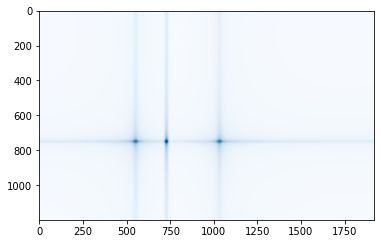

In [7]:
max_iterations = 50

pos = position[ions]
position_cam = np.column_stack((pos+target_size[1]//2,np.full(pos.shape,target_size[0]//2+dy)))
N1 = len(position_cam)
blaze_grating_phase = blaze_grating_phase_all[ions]

max_F = 0  # Initialize max_F1 to store the maximum F1 value
corresponding_F1 = 0
corresponding_F2 = 0

# from sklearn.cluster import KMeans
# num_segments = 48
# x_coords, y_coords = np.meshgrid(np.arange(slm_size[1]), np.arange(slm_size[0]))
# pixel_coords = np.vstack([x_coords.ravel(), y_coords.ravel()]).T
# kmeans = KMeans(n_clusters=num_segments, random_state=0).fit(pixel_coords)
# segments = kmeans.labels_.reshape(slm_size)

for iteration in range(max_iterations):
    random_map_superpixels = np.random.choice(N1, size=(num_superpixels_y, num_superpixels_x), p=[1/N1]*N1)
    
    # random_map_diamonds = np.random.choice(N1, size=(num_superpixels_y, num_superpixels_x), p=[1/N1]*N1)
    combined_blaze_grating_phase = blaze_RM_compose(blaze_grating_phase, num_superpixels_x, num_superpixels_y,random_map_superpixels)
    # random_map_corners = np.random.choice(N1, size=(num_superpixels_y, num_superpixels_x), p=[1/N1]*N1)
    # combined_blaze_grating_phase = blaze_RM_compose_diamond(blaze_grating_phase, slm_size, num_superpixels_x, num_superpixels_y, random_map_diamonds, random_map_corners, blaze_grating_phase_gap)
    
    # random_map_circles = np.random.choice(N1, size=(num_circle_y, num_circle_x), p=[1/N1]*N1)
    # combined_blaze_grating_phase = blaze_RM_compose_circle(blaze_grating_phase, slm_size, num_circle_x, num_circle_y , random_map_circles,blaze_grating_phase_gap)
    
    # random_phase_indices = np.random.choice(N1, size=num_segments, p=[1/N1]*N1)
    # combined_blaze_grating_phase = blaze_RM_compose_segments(blaze_grating_phase, segments, random_phase_indices)
    
    # combined_blaze_grating_phase = blaze_RM_compose_honeycomb(blaze_grating_phase, slm_size, num_superpixels_x, num_superpixels_y, random_map_superpixels, phase_gap_value= blaze_grating_phase_gap)
    
    intensity_mod, am_ff_mod = calculate_intensity(combined_blaze_grating_phase)
    F1, F2, F = fidelity_calculation(intensity_mod)
    
    if F > max_F:
        max_F = F
        corresponding_F1 = F1
        corresponding_F2 = F2
        corresponding_am_ff = am_ff_mod
        corresponding_inten = intensity_mod
        corresponding_phase = combined_blaze_grating_phase
        valid_situation_found = True 
        
    if F > 0.99:
        break  
    
print(corresponding_F1)    
print(corresponding_F2)
print(max_F)
norm_amp = (corresponding_am_ff - corresponding_am_ff.min()) / (corresponding_am_ff.max() - corresponding_am_ff.min())
plt.imshow(np.log(1 + np.sqrt(norm_amp)))


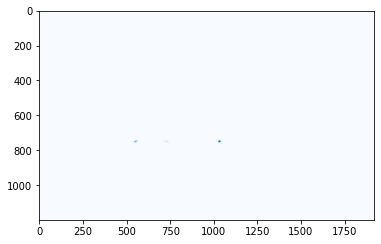

In [40]:
am_ff = corresponding_am_ff
intensity_show  = am_ff **2

plt.imshow(intensity_show)

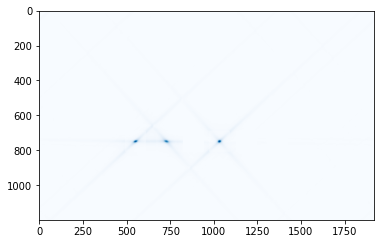

In [41]:

all = range(N)
null_indices = [i for i in all if i not in ions]
pos_null = position[null_indices]
intensity_ff = np.array(corresponding_inten)
position_null = np.column_stack((np.full(pos_null.shape,target_size[0]//2+dy),pos_null+target_size[1]//2))
position_ions = position_all_plot[ions]

for i, pos in enumerate(position_null):
    am_ff[int(pos[0])-60:int(pos[0])+60,int(pos[1])-60:int(pos[1])+60] = 0
    
from functools import reduce
  
intensity_ff_ions = intensity_ff[ions]
ratio_ff = [reduce(lambda x, y: x * y, intensity_ff_ions) / i for i in intensity_ff_ions]
ratio_ff = ratio_ff/np.sum(ratio_ff)

for i ,pos in enumerate(position_ions):
    am_ff[int(pos[0])-60:int(pos[0])+60,int(pos[1])-60:int(pos[1])+60] *= np.sqrt(ratio_ff[i]) 
plt.imshow(am_ff)


In [42]:
initial_blaze_phase_mod = corresponding_phase
holo = Hologram(target= am_ff**2, phase = initial_blaze_phase_mod, slm_shape= slm.shape)
holo.optimize(method = 'WGS-Kim', maxiter=50)
optimized_phase = holo.extract_phase()


d:\py\Python3\lib\site-packages\slmsuite\holography\algorithms.py:324: UserWarning: algorithms.py: Hologram target shape (1200, 1920) is not a power of 2; consider using .calculate_padded_shape() to pad to powers of 2 and speed up FFT computation. While some FFT solvers support other prime powers (3, 5, 7, ...), literature suggests that GPU support is best for powers of 2.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

d:\py\Python3\lib\site-packages\slmsuite\holography\algorithms.py:1169: RuntimeWarning: divide by zero encountered in divide
  mp.divide(feedback_corrected, mp.array(target_amp, copy=False), out=feedback_corrected)


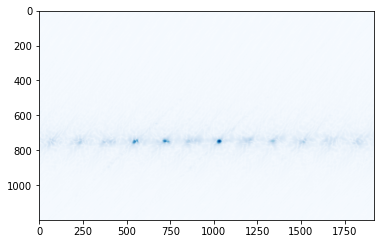

In [43]:
optimized_near_field = slm._get_measured_amplitude()* np.exp(1j * optimized_phase)
optimized_farfield = fft.fftshift(fft.fft2(fft.fftshift(optimized_near_field), norm="ortho"))
op_amp = np.abs(optimized_farfield)
op_norm_amp = (op_amp - op_amp.min())/(op_amp.max() - op_amp.min())
plt.imshow(np.log(1+np.sqrt(op_norm_amp)))

In [ ]:
plt

In [44]:
intensity_op = op_amp **2
cal_op = []
for i, pos in enumerate(position_all_plot):
    cal_op.append(np.sum(intensity_op[int(pos[0])-60:int(pos[0])+60,int(pos[1])-60:int(pos[1])+60]))
intensity_op = cal_op
background = 0
inten_op = np.array([ i- background for i in intensity_op])
all = range(N)
undesire = [ i for i in all if i not in ions]
Omega_desire_op = np.sqrt(inten_op[ions])
Omega_undesire_op = np.sqrt(inten_op[undesire])
F1_op = sum(Omega_desire_op)/(len(ions)*max(Omega_desire_op))
F2_op = 1-sum(Omega_undesire_op)/(len(undesire)*max(Omega_desire_op))
F_op = F1_op*F2_op

print(F1_op)
print(F2_op)
print(F_op)

0.6734377729144028
0.8504746492806133
0.572741753731694


d:\py\Python3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


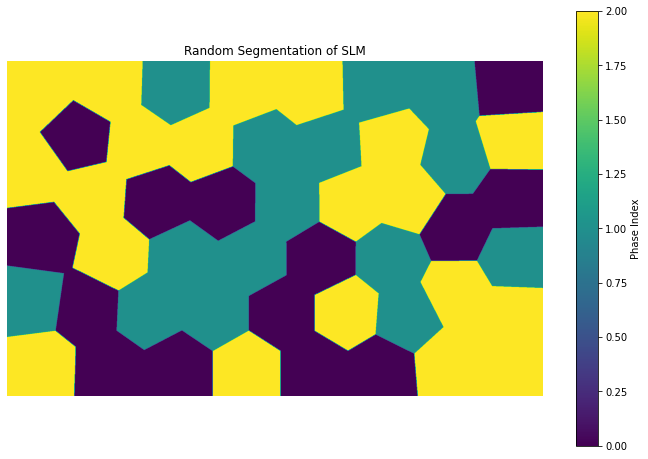

In [55]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# SLM size
slm_size = (1200, 1920)

# Number of segments
num_segments = 49

# Create a grid of pixel coordinates
x_coords, y_coords = np.meshgrid(np.arange(slm_size[1]), np.arange(slm_size[0]))
pixel_coords = np.vstack([x_coords.ravel(), y_coords.ravel()]).T

# Perform clustering
kmeans = KMeans(n_clusters=num_segments, random_state=0).fit(pixel_coords)
labels = kmeans.labels_.reshape(slm_size)

# Generate random phases for each segment
num_phases = 3  # Number of different phases
random_phases = np.random.choice(num_phases, size=num_segments, replace=True)
segment_phases = random_phases[labels]

# Visualizing the segments
plt.figure(figsize=(12, 8))
plt.imshow(segment_phases, cmap='viridis')
plt.colorbar(label='Phase Index')
plt.title('Random Segmentation of SLM')
plt.axis('off')
plt.show()

